In [604]:
import pandas as pd
import numpy as np
from datetime import datetime

import itertools
from itertools import chain, combinations
import statsmodels.formula.api as smf
import scipy.stats as scipystats
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats
from statsmodels.graphics.regressionplots import *
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import copy
import math
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

# Load data

In [605]:
path = '../input/'

In [606]:
df = pd.read_csv(f'{path}pierce.csv.gz', sep='|', compression='gzip')

In [607]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40475 entries, 0 to 40474
Data columns (total 51 columns):
booking_id                  40475 non-null int64
inmate_name                 40475 non-null object
booking_dt                  40475 non-null object
release_dt                  40475 non-null object
booking_charge_desc         40475 non-null object
booking_charge_txt          3055 non-null object
charge_release_dt           40475 non-null object
title_txt                   40475 non-null object
dob                         40475 non-null object
cause_num                   32209 non-null object
jurisdiction_cd             40475 non-null object
release_disposition_desc    40475 non-null object
post_flg                    40475 non-null object
hash_id                     40475 non-null object
gender_desc                 40475 non-null object
race_desc                   40475 non-null object
amer_indian_alaskan         40475 non-null int64
asian_pacific_island        40475 non-null i

In [608]:
df['booking_dt'] = pd.to_datetime(df['booking_dt'])
df['release_dt'] = pd.to_datetime(df['release_dt'])

In [1]:
df['release_dt'].max()

NameError: name 'df' is not defined

In [610]:
race_cols = ['amer_indian_alaskan',
             'asian_pacific_island',
             'black',
             'hispanic',
             'white']
gender_cols = ['female', 'male']

Race and gender percentages (dropping duplicate booking IDs)

In [611]:
df.drop_duplicates(subset='booking_id')[race_cols].sum()/len(df.drop_duplicates(subset='booking_id'))*100

amer_indian_alaskan      3.047813
asian_pacific_island     5.784047
black                   23.997281
hispanic                 8.406979
white                   58.763879
dtype: float64

In [612]:
df.drop_duplicates(subset='booking_id')[gender_cols].sum()/len(df.drop_duplicates(subset='booking_id'))*100

female    23.832993
male      76.167007
dtype: float64

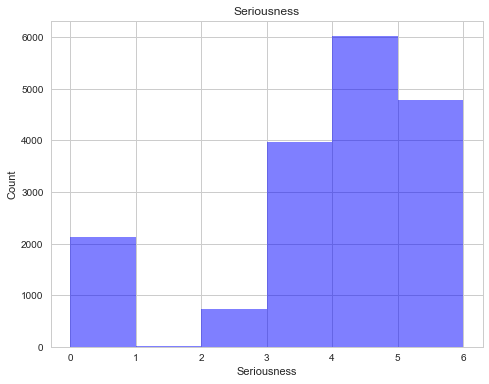

In [613]:
data = df.drop_duplicates(subset='booking_id')['max_seriousness']
num_bins = 6
# the histogram of the data
n, bins, patches = plt.hist(data.dropna(), num_bins, facecolor='blue', alpha=0.5)
 
plt.plot()
plt.xlabel('Seriousness')
plt.xticks(np.arange(0, 7, step=1))
plt.ylabel('Count')
plt.title('Seriousness')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15) 
plt.show()

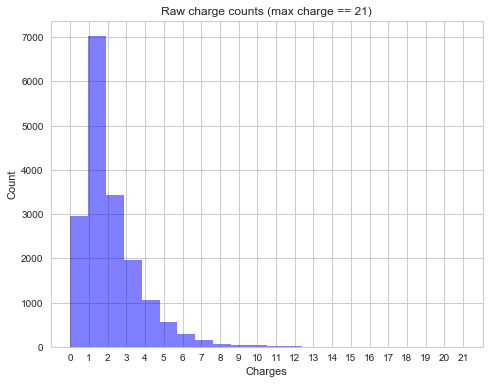

In [614]:
data = df.drop_duplicates(subset='booking_id')['charge_count']
num_bins = 22
# the histogram of the data
n, bins, patches = plt.hist(data, num_bins, facecolor='blue', alpha=0.5)
 
plt.plot()
plt.xlabel('Charges')
plt.xticks(np.arange(0, 22, step=1))
plt.ylabel('Count')
plt.title('Raw charge counts (max charge == 21)')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15) 
plt.show()

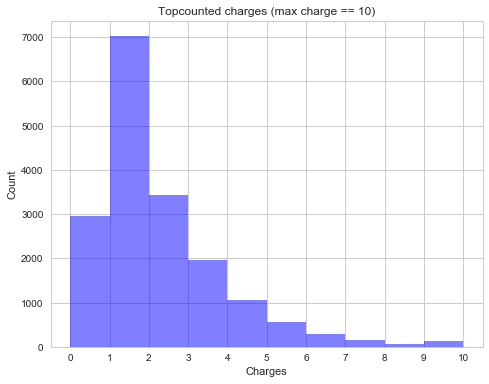

In [615]:
data = df.drop_duplicates(subset='booking_id')['charge_topcount']
num_bins = 10
# the histogram of the data
n, bins, patches = plt.hist(data, num_bins, facecolor='blue', alpha=0.5)
 
# add a 'best fit' line
plt.plot()
plt.xlabel('Charges')
plt.xticks(np.arange(0, 11, step=1))
plt.ylabel('Count')
plt.title('Topcounted charges (max charge == 10)')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

## Basic masking for immigration holds, release to immigration

Doing some basic masking and birds-eye view calculations of average time detained for different subsets of data:

In [616]:
# Booking IDs of people released to immigration
release_imm_ids = set(df[df['release_disposition_desc'] == "Immigration"]['booking_id'])

In [617]:
# Release jurisdiction == IMM. What does this mean?
juris_imm_ids = set(df[df['jurisdiction_cd'] == "IMM"]['booking_id'])

In [618]:
# Immigration hold IDs
hold_ids = set(df[df['booking_charge_desc'] == 'HOLD IMMIGRAT']['booking_id'])

In [619]:
# Booking IDs of people with canceled detainers
cancel_detainer_ids = set(df[df['release_disposition_desc'] == 'Cancel Detainer']['booking_id'])

In [620]:
hold = df[df['booking_id'].isin(hold_ids)]
no_hold = df[~df['booking_id'].isin(hold_ids)]
release_imm = df[df['booking_id'].isin(release_imm_ids)]
no_release_imm = df[~df['booking_id'].isin(release_imm_ids)]
juris_imm = df[df['booking_id'].isin(juris_imm_ids)]

In [621]:
hold_release_imm = hold[hold['booking_id'].isin(release_imm_ids)]
hold_no_release_imm = hold[~hold['booking_id'].isin(release_imm_ids)]

In [622]:
hold = hold.sort_values(by=['booking_id'])
release_imm = release_imm.sort_values(by=['booking_id'])

In [623]:
#hold.to_csv('subsets/bookings_with_imm_hold.csv', index=False)
#release_imm.to_csv('../output/released_to_imm.csv', index=False)

In [624]:
# Cases with hold with "Cancel Detainer" release disp
len(hold_ids.intersection(cancel_detainer_ids))

5

In [625]:
# Cases with holds released to immigration
len(hold_ids.intersection(release_imm_ids))

76

In [626]:
# Cases with holds release jurisdiction == IMM
len(hold_ids.intersection(juris_imm_ids))

111

In [627]:
# Canceled detainers release jurisdiction == IMM
len(juris_imm_ids.intersection(cancel_detainer_ids))

5

In [628]:
(hold['release_disposition_desc'].value_counts() / len(hold) * 100).head()

Immigration               20.365535
WSI Chain                 14.360313
Dismissed                 13.838120
Credit for Time Served     9.399478
Time Served                6.266319
Name: release_disposition_desc, dtype: float64

In [629]:
(no_hold['release_disposition_desc'].value_counts() / len(no_hold) * 100).head()

Bail Bond      14.566497
PR             10.785194
Time Served     9.737604
WSI Chain       7.794572
Dismissed       7.764641
Name: release_disposition_desc, dtype: float64

## Simple masking for immigration holds and release to immigration

In [630]:
hold_mask = df['booking_id'].isin(hold_ids)
release_imm_mask = df['booking_id'].isin(release_imm_ids)
juris_imm_mask = df['booking_id'].isin(juris_imm_ids)
cancel_detainer_mask = df['booking_id'].isin(cancel_detainer_ids)

In [631]:
df['imm_hold'] = 0
df.loc[hold_mask, 'imm_hold'] = 1

In [632]:
df['release_to_imm'] = 0
df.loc[release_imm_mask, 'release_to_imm'] = 1

In [633]:
df['juris_imm'] = 0
df.loc[release_imm_mask, 'juris_imm'] = 1

In [634]:
df['cancel_detainer'] = 0
df.loc[cancel_detainer_mask, 'cancel_detainer'] = 1

# Cleaning and masking birthplace

In [635]:
 df['place_of_birth'] = df['place_of_birth'].str.strip()

In [636]:
country = pd.read_csv('../hand/birthplace.csv')

In [637]:
df = pd.merge(df, country, on='place_of_birth', how='left')

In [638]:
df.loc[:,'born_in_us'] = df['country_of_birth'] == 'UNITED STATES OF AMERICA'

In [639]:
df[['country_of_birth', 'born_in_us']]

,country_of_birth,born_in_us
0,UNITED STATES OF AMERICA,True
1,UNITED STATES OF AMERICA,True
2,UNITED STATES OF AMERICA,True
3,UNITED STATES OF AMERICA,True
4,UNITED STATES OF AMERICA,True
5,UNITED STATES OF AMERICA,True
6,UNITED STATES OF AMERICA,True
7,UNITED STATES OF AMERICA,True
8,UNITED STATES OF AMERICA,True
9,UNITED STATES OF AMERICA,True


In [640]:
hold = df[df['imm_hold'] == True]

In [641]:
hold['country_of_birth'].value_counts()

MEXICO                            295
THAILAND                           22
GUATEMALA                          13
RUSSIA                              7
EL SALVADOR                         7
CAMBODIA                            6
SCOTLAND                            4
UNKNOWN                             4
HONDURAS                            4
PHILIPPINES                         3
FEDERATED STATES OF MICRONESIA      2
KENYA                               2
VENEZUELA                           2
UNITED STATES OF AMERICA            2
CUBA                                2
Name: country_of_birth, dtype: int64

In [642]:
hold[hold['country_of_birth'] == 'UNITED STATES OF AMERICA']

,booking_id,inmate_name,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,dob,cause_num,...,start_receipt_id,end_receipt_id,disbursed_status,disbursed_dt,imm_hold,release_to_imm,juris_imm,cancel_detainer,country_of_birth,born_in_us
23224,2017086013,"ABRAHAM, KAYODE",2017-03-27 09:05:00,2017-04-21 12:51:00,UPCS W INTENT,DRUG COURT,2017-04-21 13:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1975-07-11 00:00:00.0,16-1-01123-5,...,NaN,NaN,NaN,NaN,1,1,1,0,UNITED STATES OF AMERICA,True
23225,2017086013,"ABRAHAM, KAYODE",2017-03-27 09:05:00,2017-04-21 12:51:00,HOLD IMMIGRAT,NaN,2017-04-21 13:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1975-07-11 00:00:00.0,NaN,...,NaN,NaN,NaN,NaN,1,1,1,0,UNITED STATES OF AMERICA,True


# Bail

In [643]:
g = df.groupby(['booking_id', 'bail_receipt_id'])

In [644]:
total_fine = g.agg(lambda x: x.drop_duplicates('bail_receipt_id', keep='first').fine_amt.sum())

In [645]:
t = total_fine.to_frame('total').reset_index().set_index('booking_id')

In [646]:
t = t.groupby('booking_id')['total'].sum()

In [647]:
df.set_index('booking_id', inplace=True)

In [648]:
# I think this sums unique bail receipts for each booking id
# Why so few total records with paid bail?
df['total_fine'] = t
df['log_total_fine'] = np.log(t)

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [649]:
df.loc[2017269033]

,inmate_name,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,dob,cause_num,jurisdiction_cd,...,disbursed_status,disbursed_dt,imm_hold,release_to_imm,juris_imm,cancel_detainer,country_of_birth,born_in_us,total_fine,log_total_fine
booking_id,,,,,,,,,,,,,,,,,,,,,
2017269033,"BEESON, JAMES RAY",2017-09-26 14:02:00,2017-09-30 22:10:00,UPCS,NaN,2017-09-30 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1977-08-23 00:00:00.0,17-1-02679-6,SUP,...,D,2017-10-02 08:47:22.766,0,0,0,0,UNITED STATES OF AMERICA,True,6700.0,8.809863
2017269033,"BEESON, JAMES RAY",2017-09-26 14:02:00,2017-09-30 22:10:00,DWLS/DWLR,NaN,2017-09-30 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1977-08-23 00:00:00.0,6Z0210304,FEDM,...,D,2017-10-02 08:47:22.766,0,0,0,0,UNITED STATES OF AMERICA,True,6700.0,8.809863
2017269033,"BEESON, JAMES RAY",2017-09-26 14:02:00,2017-09-30 22:10:00,DWLS/DWLR,NaN,2017-09-30 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1977-08-23 00:00:00.0,6Z0210304,FEDM,...,D,2017-10-02 08:47:28.55,0,0,0,0,UNITED STATES OF AMERICA,True,6700.0,8.809863
2017269033,"BEESON, JAMES RAY",2017-09-26 14:02:00,2017-09-30 22:10:00,DWLS/DWLR,NaN,2017-09-30 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1977-08-23 00:00:00.0,17-1-02679-6,SUP,...,D,2017-10-02 08:47:22.766,0,0,0,0,UNITED STATES OF AMERICA,True,6700.0,8.809863
2017269033,"BEESON, JAMES RAY",2017-09-26 14:02:00,2017-09-30 22:10:00,DWLS/DWLR,NaN,2017-09-30 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1977-08-23 00:00:00.0,17-1-02679-6,SUP,...,D,2017-10-02 08:47:28.55,0,0,0,0,UNITED STATES OF AMERICA,True,6700.0,8.809863


In [650]:
df.reset_index(inplace=True)

In [651]:
df.loc[:,'paid_bail'] = df['total_fine'] > 0

In [652]:
hold = df[df['imm_hold'] == True]

In [653]:
hold[hold['paid_bail'] == True]

,booking_id,inmate_name,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,dob,cause_num,...,disbursed_dt,imm_hold,release_to_imm,juris_imm,cancel_detainer,country_of_birth,born_in_us,total_fine,log_total_fine,paid_bail
10474,2016333026,"ZAVALA URRIETA, JAIME",2016-11-28 09:49:00,2017-01-12 20:10:00,DWI,NaN,2017-01-12 14:41:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1983-06-24 00:00:00.0,XYC005103,...,NaN,1,1,1,0,MEXICO,False,1082.0,6.986566,True
10475,2016333026,"ZAVALA URRIETA, JAIME",2016-11-28 09:49:00,2017-01-12 20:10:00,HOLD IMMIGRAT,NaN,2017-01-12 20:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1983-06-24 00:00:00.0,NaN,...,NaN,1,1,1,0,MEXICO,False,1082.0,6.986566,True
10476,2016333026,"ZAVALA URRIETA, JAIME",2016-11-28 09:49:00,2017-01-12 20:10:00,NON-SUPPORT,NaN,2017-01-12 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1983-06-24 00:00:00.0,133031859,...,2017-01-13 08:50:46.026,1,1,1,0,MEXICO,False,1082.0,6.986566,True
22487,2017079033,"ZAVALA URRIETA, JAIME",2017-03-20 13:50:00,2017-03-21 17:35:00,HOLD IMMIGRAT,NaN,2017-03-21 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1983-06-24 00:00:00.0,NaN,...,NaN,1,0,0,1,MEXICO,False,500.0,6.214608,True
22488,2017079033,"ZAVALA URRIETA, JAIME",2017-03-20 13:50:00,2017-03-21 17:35:00,MAL MISCH 3 /DV,NaN,2017-03-21 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1983-06-24 00:00:00.0,D00048498,...,2017-03-22 08:36:07.553,1,0,0,1,MEXICO,False,500.0,6.214608,True
22489,2017079033,"ZAVALA URRIETA, JAIME",2017-03-20 13:50:00,2017-03-21 17:35:00,CIVIL CNTMPT OF CRT,NaN,2017-03-21 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1983-06-24 00:00:00.0,133031859,...,NaN,1,0,0,1,MEXICO,False,500.0,6.214608,True
25242,2017106004,"ROSAS BEJAR, RAMON DONATO",2017-04-16 01:51:00,2017-04-27 16:40:00,HARASS /DV,NaN,2017-04-27 21:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1986-03-25 00:00:00.0,D48974,...,2017-04-28 08:39:48.196,1,0,0,1,MEXICO,False,1000.0,6.907755,True
25243,2017106004,"ROSAS BEJAR, RAMON DONATO",2017-04-16 01:51:00,2017-04-27 16:40:00,"FEL HARASS-DV, DV-THREATS/DEATH THRT",NaN,2017-04-17 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1986-03-25 00:00:00.0,NaN,...,NaN,1,0,0,1,MEXICO,False,1000.0,6.907755,True
25244,2017106004,"ROSAS BEJAR, RAMON DONATO",2017-04-16 01:51:00,2017-04-27 16:40:00,HOLD IMMIGRAT,NaN,2017-04-25 21:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1986-03-25 00:00:00.0,NaN,...,NaN,1,0,0,1,MEXICO,False,1000.0,6.907755,True
25245,2017106004,"ROSAS BEJAR, RAMON DONATO",2017-04-16 01:51:00,2017-04-27 16:40:00,INTIM W/WPN /DV,NaN,2017-04-27 21:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1986-03-25 00:00:00.0,D48974,...,2017-04-28 08:39:48.196,1,0,0,1,MEXICO,False,1000.0,6.907755,True


# Drop duplicates

Subsequent cell drops duplicate booking IDs so count = individual bookings, not charges. Mask any variables that we want to analyze further.

In [654]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40475 entries, 0 to 40474
Data columns (total 60 columns):
booking_id                  40475 non-null int64
inmate_name                 40475 non-null object
booking_dt                  40475 non-null datetime64[ns]
release_dt                  40475 non-null datetime64[ns]
booking_charge_desc         40475 non-null object
booking_charge_txt          3055 non-null object
charge_release_dt           40475 non-null object
title_txt                   40475 non-null object
dob                         40475 non-null object
cause_num                   32209 non-null object
jurisdiction_cd             40475 non-null object
release_disposition_desc    40475 non-null object
post_flg                    40475 non-null object
hash_id                     40475 non-null object
gender_desc                 40475 non-null object
race_desc                   40475 non-null object
amer_indian_alaskan         40475 non-null int64
asian_pacific_island        

In [655]:
df = df.drop_duplicates(subset=['booking_id'])

In [656]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17652 entries, 0 to 40474
Data columns (total 60 columns):
booking_id                  17652 non-null int64
inmate_name                 17652 non-null object
booking_dt                  17652 non-null datetime64[ns]
release_dt                  17652 non-null datetime64[ns]
booking_charge_desc         17652 non-null object
booking_charge_txt          1506 non-null object
charge_release_dt           17652 non-null object
title_txt                   17652 non-null object
dob                         17652 non-null object
cause_num                   13512 non-null object
jurisdiction_cd             17652 non-null object
release_disposition_desc    17652 non-null object
post_flg                    17652 non-null object
hash_id                     17652 non-null object
gender_desc                 17652 non-null object
race_desc                   17652 non-null object
amer_indian_alaskan         17652 non-null int64
asian_pacific_island        

In [657]:
df.set_index('booking_id',inplace=True)

# More descriptive analysis

Bookings with immigration holds have longer detention time. Using logged time makes this clearer.

In [658]:
hold_order = ['No hold', 'Hold']

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


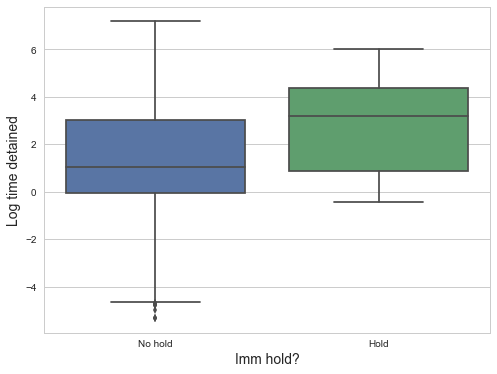

In [659]:
df['imm_hold_text'] = df['imm_hold'].replace({0: 'No hold', 1: 'Hold'})
bplot1 = sns.boxplot(data=df, y='log_time_detained', x='imm_hold_text', order=hold_order)
bplot1.set_xlabel('Imm hold?', fontsize=14)
bplot1.set_ylabel('Log time detained', fontsize=14)

A couple outliers with lots of charges in imm_hold category?

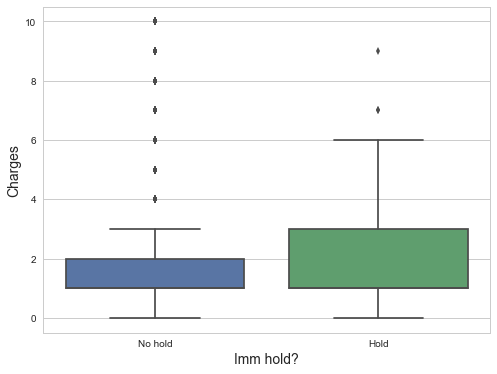

In [660]:
bplot2 = sns.boxplot(data=df, y='charge_topcount', x='imm_hold_text', order=hold_order)
bplot2.set_xlabel('Imm hold?', fontsize=14)
bplot2.set_ylabel('Charges', fontsize=14)

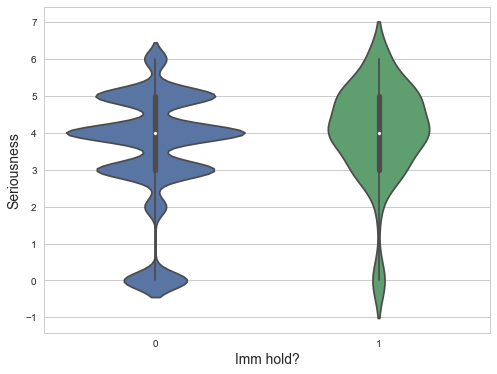

In [661]:
bplot2 = sns.violinplot(data=df, y='max_seriousness', x='imm_hold')
bplot2.set_xlabel('Imm hold?', fontsize=14)
bplot2.set_ylabel('Seriousness', fontsize=14)

Felonies detained longer.

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


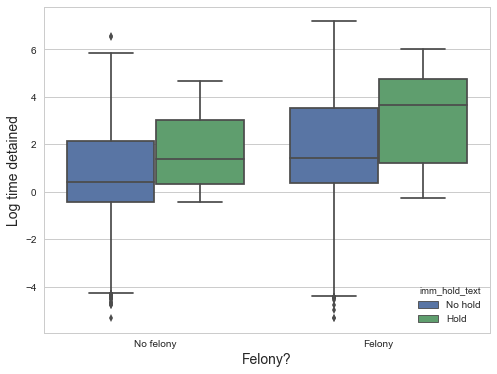

In [662]:
df['felony_text'] = df['felony'].replace({0: 'No felony', 1: 'Felony'})
fel_order = ['No felony', 'Felony']
bplot2 = sns.boxplot(data=df, y='log_time_detained', x='felony_text', hue='imm_hold_text', order=fel_order)
bplot2.set_xlabel('Felony?', fontsize=14)
bplot2.set_ylabel('Log time detained', fontsize=14)

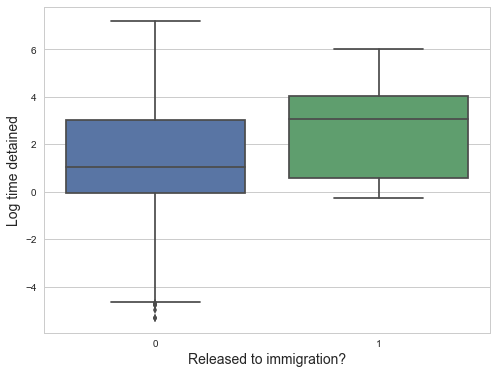

In [663]:
d0 = df[df['release_to_imm'] == 0]['log_time_detained']
d1 = df[df['release_to_imm'] == 1]['log_time_detained']
bplot2 = sns.boxplot(data=[d0, d1])
bplot2.set_xlabel('Released to immigration?', fontsize=14)
bplot2.set_ylabel('Log time detained', fontsize=14)

More serious charges generally detained longer. Lots of outliers for 0 seriousness, probably because it includes holds, community custody, etc.

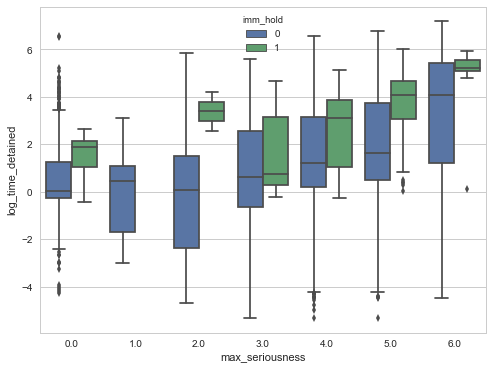

In [664]:
plt = sns.boxplot(data=df, x="max_seriousness", y="log_time_detained", hue='imm_hold')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

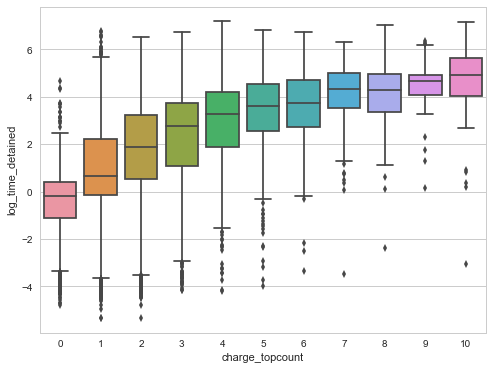

In [665]:
plt = sns.boxplot(data=df, x="charge_topcount", y="log_time_detained")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [666]:
race_order = ['WHITE',
         'BLACK',
         'HISPANIC',
         'ASIAN/PACIFIC ISLAND',
         'AMER INDIAN/ALASKAN']

Heavy `charge_count` bias for `BLACK` and `AMER INDIAN/ALASKAN`, other race categories roughly similar. Using topcounted charges emphasizes this.

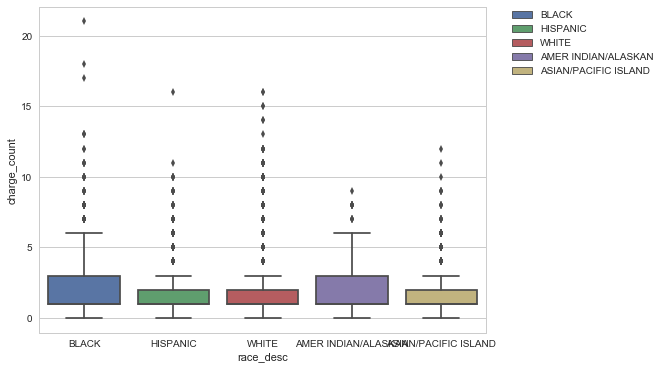

In [667]:
plt = sns.boxplot(data=df, x="race_desc", y="charge_count", hue="race_desc", dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

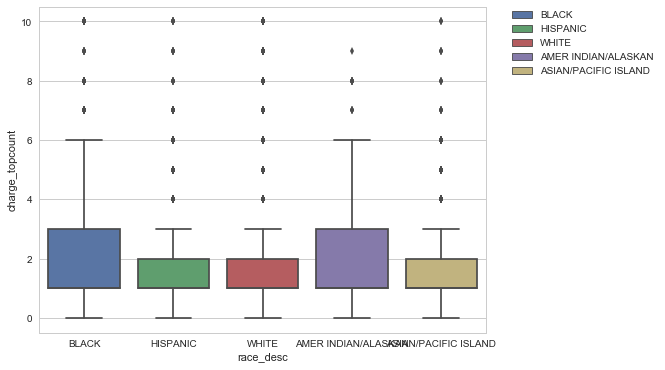

In [668]:
plt = sns.boxplot(data=df, x="race_desc", y="charge_topcount", hue="race_desc", dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Time in detention is roughly similar across race categories.

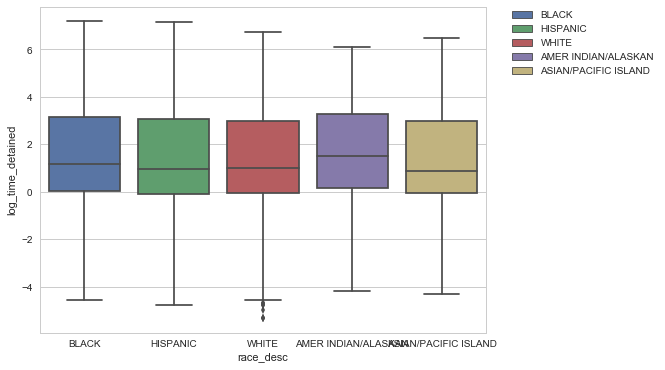

In [669]:
plt = sns.boxplot(data=df, x="race_desc", y="log_time_detained", hue="race_desc", dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

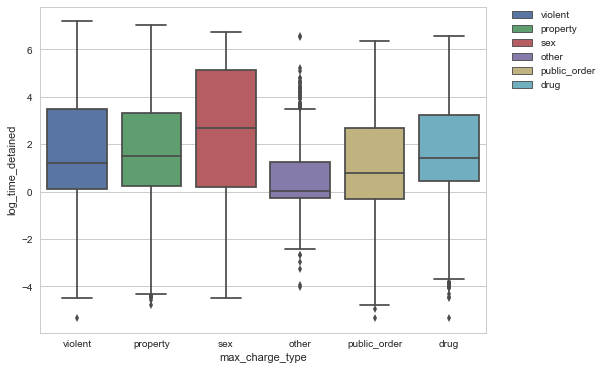

In [670]:
plt = sns.boxplot(data=df, x="max_charge_type", y="log_time_detained", hue="max_charge_type", dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

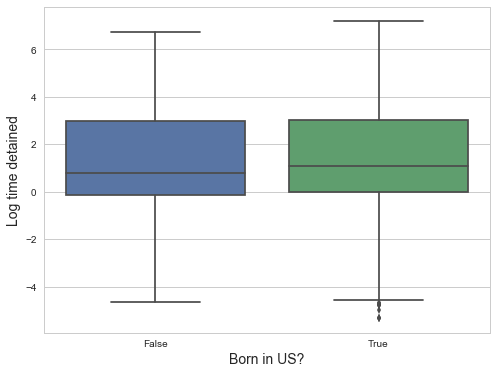

In [671]:
bplot1 = sns.boxplot(data=df, y='log_time_detained', x='born_in_us')
bplot1.set_xlabel('Born in US?', fontsize=14)
bplot1.set_ylabel('Log time detained', fontsize=14)

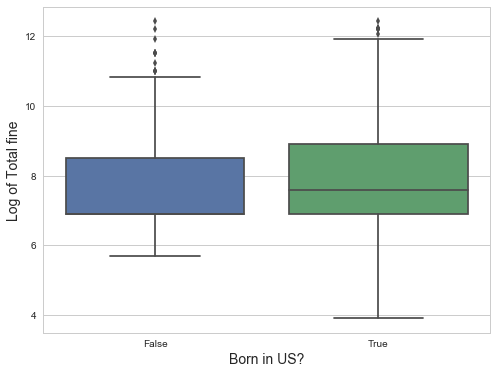

In [672]:
bplot1 = sns.boxplot(data=df, y='log_total_fine', x='born_in_us')
bplot1.set_xlabel('Born in US?', fontsize=14)
bplot1.set_ylabel('Log of Total fine', fontsize=14)

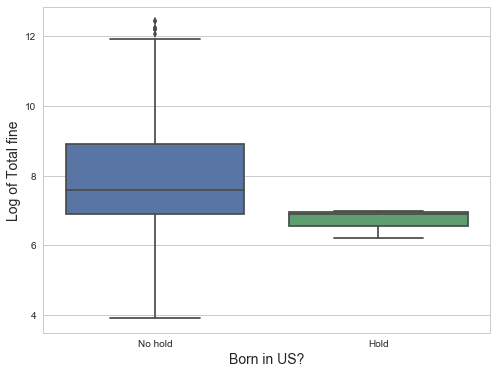

In [673]:
bplot1 = sns.boxplot(data=df, y='log_total_fine', x='imm_hold_text')
bplot1.set_xlabel('Born in US?', fontsize=14)
bplot1.set_ylabel('Log of Total fine', fontsize=14)

# Basic stats on hold demographics

In [674]:
race_holds = df.groupby('race_desc')['imm_hold'].sum()

In [675]:
n = df['race_desc'].value_counts()

In [676]:
race_hold_df = pd.DataFrame([n, race_holds]).T

In [677]:
race_hold_df.columns = ['n', 'imm_hold']

In [678]:
race_hold_df['percent'] = race_hold_df['imm_hold']/race_hold_df['n'] *100

In [679]:
race_hold_df

,n,imm_hold,percent
WHITE,10373,5,0.048202
BLACK,4236,3,0.070822
HISPANIC,1484,99,6.671159
ASIAN/PACIFIC ISLAND,1021,8,0.783546
AMER INDIAN/ALASKAN,538,0,0.000000


In [680]:
df.groupby('race_desc')['imm_hold'].value_counts()

race_desc             imm_hold
AMER INDIAN/ALASKAN   0             538
ASIAN/PACIFIC ISLAND  0            1013
                      1               8
BLACK                 0            4233
                      1               3
HISPANIC              0            1385
                      1              99
WHITE                 0           10368
                      1               5
Name: imm_hold, dtype: int64

In [681]:
sns.set(style="whitegrid", color_codes=True)

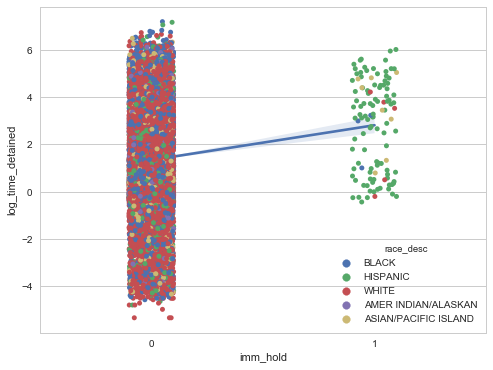

In [682]:
# a4_dims = (11.7, 8.27)
# fig, ax = plt.subplots(figsize=a4_dims)
sns.stripplot(x="imm_hold", y="log_time_detained", hue="race_desc", marker='o', data=df, jitter=True);
sns.regplot(x="imm_hold", y="log_time_detained", truncate=True, marker='', data=df);

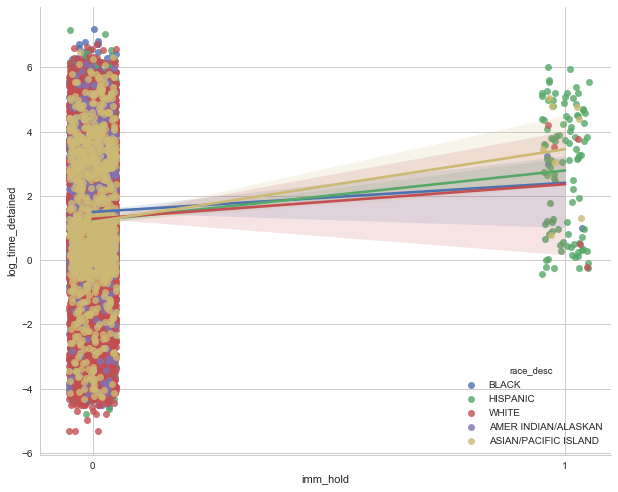

In [683]:
plt = sns.lmplot(x="imm_hold", y="log_time_detained", hue="race_desc", truncate=True, markers='o', legend_out=False, x_jitter=0.05, data=df, size=7, aspect=1.25);
plt.set(xticks=[0, 1])
plt.despine()

In [684]:
hold = df['imm_hold'] == 1
no_hold = df['imm_hold'] == 0
release_to_imm = df['release_to_imm'] == 1
no_release_to_imm = df['release_to_imm'] == 0

In [685]:
df[hold].describe()

,amer_indian_alaskan,asian_pacific_island,black,hispanic,white,female,male,time_detained,log_time_detained,seriousness,...,bail_receipt_id,fine_amt,start_receipt_id,end_receipt_id,imm_hold,release_to_imm,juris_imm,cancel_detainer,total_fine,log_total_fine
count,115.0,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,...,1.0,1.0,1.0,1.0,115.0,115.000000,115.000000,115.000000,3.000000,3.000000
mean,0.0,0.069565,0.026087,0.860870,0.043478,0.034783,0.965217,57.779825,2.807479,2.373913,...,101451.0,1000.0,0.0,106273.0,1.0,0.660870,0.660870,0.043478,860.666667,6.702977
std,0.0,0.255526,0.160092,0.347597,0.204824,0.184031,0.184031,78.822765,1.890382,1.889309,...,NaN,NaN,NaN,NaN,0.0,0.475486,0.475486,0.204824,315.025925,0.424771
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.647222,-0.435066,0.000000,...,101451.0,1000.0,0.0,106273.0,1.0,0.000000,0.000000,0.000000,500.000000,6.214608
25%,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.377083,0.865001,0.000000,...,101451.0,1000.0,0.0,106273.0,1.0,0.000000,0.000000,0.000000,750.000000,6.561182
50%,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,24.320139,3.191305,3.000000,...,101451.0,1000.0,0.0,106273.0,1.0,1.000000,1.000000,0.000000,1000.000000,6.907755
75%,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,81.071875,4.395332,4.000000,...,101451.0,1000.0,0.0,106273.0,1.0,1.000000,1.000000,0.000000,1041.000000,6.947161
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,405.518056,6.005165,6.000000,...,101451.0,1000.0,0.0,106273.0,1.0,1.000000,1.000000,1.000000,1082.000000,6.986566


In [686]:
df.describe()

,amer_indian_alaskan,asian_pacific_island,black,hispanic,white,female,male,time_detained,log_time_detained,seriousness,...,bail_receipt_id,fine_amt,start_receipt_id,end_receipt_id,imm_hold,release_to_imm,juris_imm,cancel_detainer,total_fine,log_total_fine
count,17652.000000,17652.000000,17652.000000,17652.00000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,...,3083.000000,3083.000000,3083.0,3083.0,17652.000000,17652.000000,17652.000000,17652.000000,3511.000000,3511.000000
mean,0.030478,0.057840,0.239973,0.08407,0.587639,0.238330,0.761670,25.359933,1.345339,2.992635,...,101222.879987,7471.743107,0.0,106273.0,0.006515,0.004362,0.004362,0.023850,8187.050222,-inf
std,0.171904,0.233448,0.427079,0.27750,0.492273,0.426074,0.426074,62.996963,2.142756,1.616985,...,1152.314160,18246.374576,0.0,0.0,0.080454,0.065904,0.065904,0.152586,18953.682051,NaN
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.004861,-5.326488,0.000000,...,99232.000000,0.000000,0.0,106273.0,0.000000,0.000000,0.000000,0.000000,0.000000,-inf
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.965972,-0.034620,2.000000,...,100211.500000,1000.000000,0.0,106273.0,0.000000,0.000000,0.000000,0.000000,1000.000000,6.907755
50%,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,2.836111,1.042434,3.000000,...,101250.000000,1000.000000,0.0,106273.0,0.000000,0.000000,0.000000,0.000000,2000.000000,7.600902
75%,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,20.833507,3.036563,4.000000,...,102218.000000,5000.000000,0.0,106273.0,0.000000,0.000000,0.000000,0.000000,7500.000000,8.922658
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1314.554167,7.181253,6.000000,...,103211.000000,250000.000000,0.0,106273.0,1.000000,1.000000,1.000000,1.000000,250000.000000,12.429216


In [687]:
df[hold]['max_charge_type'].value_counts()

public_order    35
violent         27
drug            22
property        17
sex              8
other            6
Name: max_charge_type, dtype: int64

In [688]:
df[hold]['max_charge_desc'].value_counts().head()

DWI                       15
UPCS                      11
UPCS W INTENT              8
POSSESS STOLEN VEHICLE     6
ASSAULT 4 /DV              5
Name: max_charge_desc, dtype: int64

# Correlation of felony with hold category

In [689]:
df[hold]['felony'].value_counts() / sum(hold) * 100

1    73.913043
0    26.086957
Name: felony, dtype: float64

In [690]:
df[~hold]['felony'].value_counts()

1    10721
0     6816
Name: felony, dtype: int64

In [691]:
df['felony'].value_counts() / len(df) * 100

1    61.216859
0    38.783141
Name: felony, dtype: float64

In [692]:
pd.crosstab(df.felony, df.imm_hold, margins=True, normalize='columns') * 100

imm_hold,0,1,All
felony,,,
0,38.866397,26.086957,38.783141
1,61.133603,73.913043,61.216859


In [693]:
pd.crosstab(df.felony, df.imm_hold)

imm_hold,0,1
felony,,
0,6816,30
1,10721,85


Significant relationship between felony and presence of immigration hold

In [694]:
scipystats.chi2_contingency(pd.crosstab(df.felony, df.imm_hold))

(7.3299779868669797,
 0.0067813884427315885,
 1,
 array([[  6801.39938817,     44.60061183],
        [ 10735.60061183,     70.39938817]]))

In [695]:
scipystats.chi2_contingency(pd.crosstab(df.max_seriousness, df.imm_hold))

(12.766834322308034,
 0.046891736755448714,
 6,
 array([[  2.11413642e+03,   1.38635849e+01],
        [  1.39087922e+01,   9.12077952e-02],
        [  7.23257195e+02,   4.74280535e+00],
        [  3.95009699e+03,   2.59030138e+01],
        [  5.97879368e+03,   3.92063222e+01],
        [  4.01566701e+03,   2.63329934e+01],
        [  7.41139927e+02,   4.86007251e+00]]))

In [696]:
pd.crosstab(df.race_desc, df.felony, margins=True, normalize='index') * 100

felony,0,1
race_desc,,
AMER INDIAN/ALASKAN,41.635688,58.364312
ASIAN/PACIFIC ISLAND,36.826641,63.173359
BLACK,37.865911,62.134089
HISPANIC,37.398922,62.601078
WHITE,39.400366,60.599634
All,38.783141,61.216859


Insignificant relationship between felony and race

In [697]:
scipystats.chi2_contingency(pd.crosstab(df.race_desc, df.felony))

(7.8532300839048235,
 0.097104953187627005,
 4,
 array([[  208.65329708,   329.34670292],
        [  395.97586676,   625.02413324],
        [ 1642.85384092,  2593.14615908],
        [  575.54180829,   908.45819171],
        [ 4022.97518695,  6350.02481305]]))

In [698]:
df[hold]['max_seriousness'].value_counts()

4.0    42
5.0    34
3.0    22
6.0     9
0.0     6
2.0     2
Name: max_seriousness, dtype: int64

In [699]:
df[hold]['charge_topcount'].describe()

count    115.000000
mean       1.965217
std        1.695869
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        9.000000
Name: charge_topcount, dtype: float64

In [700]:
print(df[hold].groupby('race_desc')['race_desc'].count() / len(df[hold]) * 100)
print('\n')
print(f'n = {len(hold)}')

race_desc
ASIAN/PACIFIC ISLAND     6.956522
BLACK                    2.608696
HISPANIC                86.086957
WHITE                    4.347826
Name: race_desc, dtype: float64


n = 17652


In [701]:
print(df.groupby('race_desc')['race_desc'].count() / len(df) * 100)
print('\n')
print(f'n = {len(df)}')

race_desc
AMER INDIAN/ALASKAN      3.047813
ASIAN/PACIFIC ISLAND     5.784047
BLACK                   23.997281
HISPANIC                 8.406979
WHITE                   58.763879
Name: race_desc, dtype: float64


n = 17652


In [702]:
# Race breakdown of cases released to immigration:
print(df.groupby('race_desc')['release_to_imm'].sum())

race_desc
AMER INDIAN/ALASKAN      0
ASIAN/PACIFIC ISLAND     3
BLACK                    2
HISPANIC                67
WHITE                    5
Name: release_to_imm, dtype: int64


In [703]:
# Percent of bookings with immigration holds released to immigration
print(sum(df[hold]['release_to_imm'] == 1) / len(df[hold]) * 100)
print('\n')
print(f'n = {len(df[hold])}')

66.08695652173913


n = 115


In [704]:
hispanic = df[df.hispanic == 1]

In [705]:
hispanic_with_hold = hispanic[hispanic.imm_hold == 1]
hispanic_release_to_imm = hispanic[hispanic.release_to_imm == 1]

Percents of hispanics with immigration holds; released to immigration:

In [706]:
print(len(hispanic_with_hold) / len(hispanic) * 100)
print(len(hispanic_release_to_imm) / len(hispanic) * 100)
print('\n')
print(f'n={len(hispanic)}')

6.671159029649595
4.514824797843666


n=1484


In [707]:
df.groupby('imm_hold')['felony'].sum() / df.groupby('imm_hold')['felony'].count() * 100

imm_hold
0    61.133603
1    73.913043
Name: felony, dtype: float64

In [708]:
df.groupby('imm_hold')['max_seriousness'].mean()

imm_hold
0    3.517934
1    4.017391
Name: max_seriousness, dtype: float64

In [709]:
df.groupby('imm_hold')['charge_topcount'].mean()

imm_hold
0    1.781605
1    1.965217
Name: charge_topcount, dtype: float64

In [710]:
hold_felony_mean_time = df[hold][df[hold]['felony'] == 1]['time_detained'].mean()
hold_misdem_mean_time = df[hold][df[hold]['misdemeanor'] == 1]['time_detained'].mean()
# hold_no_charge_mean_time = df[hold][df[hold]['no_charge'] == 1]['time_detained'].mean()
no_hold_felony_mean_time = df[~hold][df[~hold]['felony'] == 1]['time_detained'].mean()
no_hold_misdem_mean_time = df[~hold][df[~hold]['misdemeanor'] == 1]['time_detained'].mean()
# no_hold_no_charge_mean_time = df[~hold][df[~hold]['no_charge'] == 1]['time_detained'].mean()

In [711]:
data = {'mean_time_detained': [
no_hold_felony_mean_time,
no_hold_misdem_mean_time,
hold_felony_mean_time,
hold_misdem_mean_time],
       'charge_category': ['felony', 'misdemeanor', 'felony', 'misdemeanor'],
       'hold': ['no_hold', 'no_hold', 'hold', 'hold']}

In [712]:
table = pd.DataFrame(data=data)

In [713]:
table

,mean_time_detained,charge_category,hold
0,35.554819,felony,no_hold
1,5.881032,misdemeanor,no_hold
2,72.261936,felony,hold
3,40.165278,misdemeanor,hold


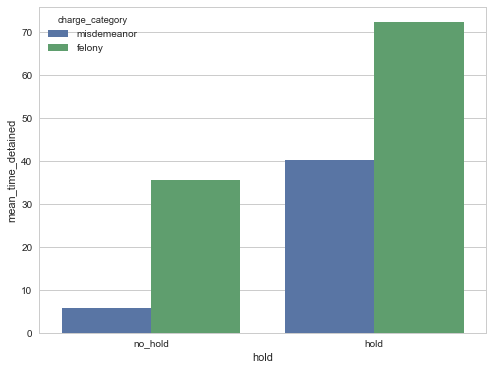

In [714]:
ax = sns.barplot(x='hold', y='mean_time_detained', hue='charge_category', hue_order=['misdemeanor', 'felony'], data=table)

In [715]:
ttest = scipystats.ttest_ind(df[hold]['time_detained'], df[~hold]['time_detained'])

In [716]:
ttest

Ttest_indResult(statistic=5.5414746404560491, pvalue=3.0422420381957703e-08)

In [717]:
ttest.pvalue

3.0422420381957703e-08

# Regressions

In [718]:
# Using topcounted charge values
formula = "log_time_detained ~ imm_hold + charge_topcount + male + black + hispanic + amer_indian_alaskan + asian_pacific_island + max_seriousness + felony + drug + sex + property + violent + other"
reg = smf.ols(formula = formula, data = df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_time_detained   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     580.9
Date:                Mon, 20 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:34:39   Log-Likelihood:                -35152.
No. Observations:               17652   AIC:                         7.033e+04
Df Residuals:                   17637   BIC:                         7.045e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9658      0.086    -22.816      0.000      -2.135      -1.797
imm_hold                 1.2302      0.171      7.210      0.000       0.896       1.565
charge_topcount          0.5989      0.009     69.627      0.000       0.582       0.616
male                     0.1449      0.032      4.559      0.000       0.083       0.207
black                    0.0991      0.033      3.041      0.002       0.035       0.163
hispanic                -0.0685      0.051     -1.353      0.176      -0.168       0.031
amer_indian_alaskan      0.3007      0.079      3.829      0.000       0.147       0.455
asian_pacific_island    -0.1007      0.058     -1.729      0.084      -0.215       0.013
max_seriousness          0.5454      0.029     19.090      0.000       0.489       0.601
felony                  -0.1484      0.064     -2.330      0.020      -0.273      -0.024
drug                     0.3004      0.057      5.310      0.000       0.190       0.411
sex                      0.3398      0.113      3.002      0.003       0.118       0.562
property                -0.1770      0.041     -4.276      0.000      -0.258      -0.096
violent                  0.2460      0.045      5.475      0.000       0.158       0.334
other                    1.8335      0.092     19.876      0.000       1.653       2.014
==============================================================================
Omnibus:                      393.089   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              481.010
Skew:                          -0.303   Prob(JB):                    3.55e-105
Kurtosis:                       3.535   Cond. No.                         58.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [719]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
amer_indian_alaskan,17652.0,3.047813e-02,0.171904,0.000000e+00,0.000000,0.000000,0.000000,1.000000
asian_pacific_island,17652.0,5.784047e-02,0.233448,0.000000e+00,0.000000,0.000000,0.000000,1.000000
black,17652.0,2.399728e-01,0.427079,0.000000e+00,0.000000,0.000000,0.000000,1.000000
hispanic,17652.0,8.406979e-02,0.277500,0.000000e+00,0.000000,0.000000,0.000000,1.000000
white,17652.0,5.876388e-01,0.492273,0.000000e+00,0.000000,1.000000,1.000000,1.000000
female,17652.0,2.383299e-01,0.426074,0.000000e+00,0.000000,0.000000,0.000000,1.000000
male,17652.0,7.616701e-01,0.426074,0.000000e+00,1.000000,1.000000,1.000000,1.000000
time_detained,17652.0,2.535993e+01,62.996963,4.861111e-03,0.965972,2.836111,20.833507,1314.554167
log_time_detained,17652.0,1.345339e+00,2.142756,-5.326488e+00,-0.034620,1.042434,3.036563,7.181253
seriousness,17652.0,2.992635e+00,1.616985,0.000000e+00,2.000000,3.000000,4.000000,6.000000


In [720]:
reg.params

Intercept              -1.965759
imm_hold                1.230190
charge_topcount         0.598926
male                    0.144873
black                   0.099078
hispanic               -0.068464
amer_indian_alaskan     0.300671
asian_pacific_island   -0.100655
max_seriousness         0.545354
felony                 -0.148445
drug                    0.300404
sex                     0.339773
property               -0.176968
violent                 0.246035
other                   1.833480
dtype: float64

In [721]:
# Does this work as a predictive equation? Reference categories: race = white, crime type = public order
log_time_detained = (reg.params['Intercept'] + 
                    (reg.params['imm_hold'] * 1) + 
                    (reg.params['charge_topcount'] * 1.7) +
                    (reg.params['male'] * 1) +
                    (reg.params['black'] * 0) +
                    (reg.params['hispanic'] * 1) +
                    (reg.params['amer_indian_alaskan'] * 0) +
                    (reg.params['asian_pacific_island'] * 0) +
                    (reg.params['max_seriousness'] * 3.52) +
                    (reg.params['felony'] * 1) +
                    (reg.params['drug'] * 0) +
                    (reg.params['sex'] * 0) +
                    (reg.params['property'] * 0) +
                    (reg.params['violent'] * 0) +
                    (reg.params['other'] * 0))
predicted_time_detained_0 = np.power(np.e, log_time_detained)
print(f'{predicted_time_detained_0}')

8.416686245774228


In [722]:
# Does this work as a predictive equation? Reference categories: race = white, crime type = public order
log_time_detained = (reg.params['Intercept'] + 
                    (reg.params['imm_hold'] * 0) + 
                    (reg.params['charge_topcount'] * 1.7) +
                    (reg.params['male'] * 1) +
                    (reg.params['black'] * 0) +
                    (reg.params['hispanic'] * 1) +
                    (reg.params['amer_indian_alaskan'] * 0) +
                    (reg.params['asian_pacific_island'] * 0) +
                    (reg.params['max_seriousness'] * 3.52) +
                    (reg.params['felony'] * 1) +
                    (reg.params['drug'] * 0) +
                    (reg.params['sex'] * 0) +
                    (reg.params['property'] * 0) +
                    (reg.params['violent'] * 0) +
                    (reg.params['other'] * 0))
predicted_time_detained_1 = np.power(np.e, log_time_detained)
print(f'{predicted_time_detained_1}')

2.459666993565452


In [723]:
predicted_time_detained_0 / predicted_time_detained_1

3.4218803877892743

In [724]:
(predicted_time_detained_0 - predicted_time_detained_1)

5.9570192522087755

In [725]:
(np.power(np.e, reg.params) - 1) * 100

Intercept               -85.995041
imm_hold                242.188039
charge_topcount          82.016307
male                     15.589301
black                    10.415219
hispanic                 -6.617279
amer_indian_alaskan      35.076540
asian_pacific_island     -9.575472
max_seriousness          72.521910
felony                  -13.795284
drug                     35.040471
sex                      40.462809
property                -16.219366
violent                  27.894461
other                   525.561825
dtype: float64